In [1]:
import json
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset

In [7]:
test_data = load_dataset('beanham/spatial_join', split='test')
fp_data = load_dataset('beanham/spatial_join', split='fp')
fn_data = load_dataset('beanham/spatial_join', split='fn')
test_gt=np.array(test_data['label'])
fp_gt=np.array(fp_data['label'])
fn_gt=np.array(fn_data['label'])
models=['mistral','qwen', 'llama3','gpt-4o-mini-2024-07-18', 'gpt-4o-mini-2024-07-18-vision']
ft_fs = [['False', 'False'],['True', 'False']]

## Accuracy

In [8]:
table=[]
results={}
for model in models:
    preds={}
    if model == 'gpt-4o-mini-2024-07-18-vision':
        ft_fs = [['False', 'False']]
    for ft, fs in ft_fs:        
        test=np.load(f'{model}_finetuned_{ft}_fewshot_{fs}_test.npy')
        fp=np.load(f'{model}_finetuned_{ft}_fewshot_{fs}_fp.npy')
        fn=np.load(f'{model}_finetuned_{ft}_fewshot_{fs}_fn.npy')
        
        ## post-process for format
        test=[i.replace('Label:', '').split()[0] for i in test]
        fp=[i.replace('Label:', '').split()[0] for i in fp]
        fn=[i.replace('Label:', '').split()[0] for i in fn]
        
        test=np.array([int(i) if i.isnumeric() else 2 for i in test])
        fp=np.array([int(i) if i.isnumeric() else 2 for i in fp])
        fn=np.array([int(i) if i.isnumeric() else 2 for i in fn])
        
        ## accuracy calculation
        test_acc = (test_gt==test).mean()
        fp_acc = (fp_gt==fp).mean()
        fn_acc = (fn_gt==fn).mean()
        
        ## save results
        table.append([model, ft, test_acc, fp_acc, fn_acc])
        preds['test']=test
        preds['fp']=fp
        preds['fp']=fn        
    results[model]=preds    
table=pd.DataFrame(table, columns=['model', 'finetuned', 'test', 'fp', 'fn'])
table.sort_values('finetuned')        

,model,finetuned,test,fp,fn
0,mistral,False,0.473753,0.750000,0.304878
2,qwen,False,0.454068,0.952381,0.000000
4,llama3,False,0.419948,0.892857,0.000000
6,gpt-4o-mini-2024-07-18,False,0.461942,0.952381,0.060976
8,gpt-4o-mini-2024-07-18-vision,False,0.632546,0.250000,0.707317
1,mistral,True,0.919948,0.250000,0.500000
3,qwen,True,0.917323,0.642857,0.292683
5,llama3,True,0.956693,0.416667,0.341463
7,gpt-4o-mini-2024-07-18,True,0.977690,0.416667,0.390244


## Error Analysis

In [4]:
with open('../../2024-spatial-join-exp/join_task_data/index.txt', 'r') as f:
    index=json.load(f)
test_index=np.array(index['test'])
gpt4_wrong_predictions=test_index[np.where(~(results['gpt-4o-mini-2024-07-18']['test']==test_gt))[0]]
gpt4_wrong_predictions

array(['negative_490', 'positive_2151', 'positive_184', 'positive_750',
       'positive_2298', 'negative_1763', 'positive_2299', 'negative_2110',
       'positive_73', 'positive_879', 'positive_427', 'negative_1084',
       'positive_13', 'negative_1519', 'negative_496', 'positive_1691',
       'positive_477'], dtype='<U13')

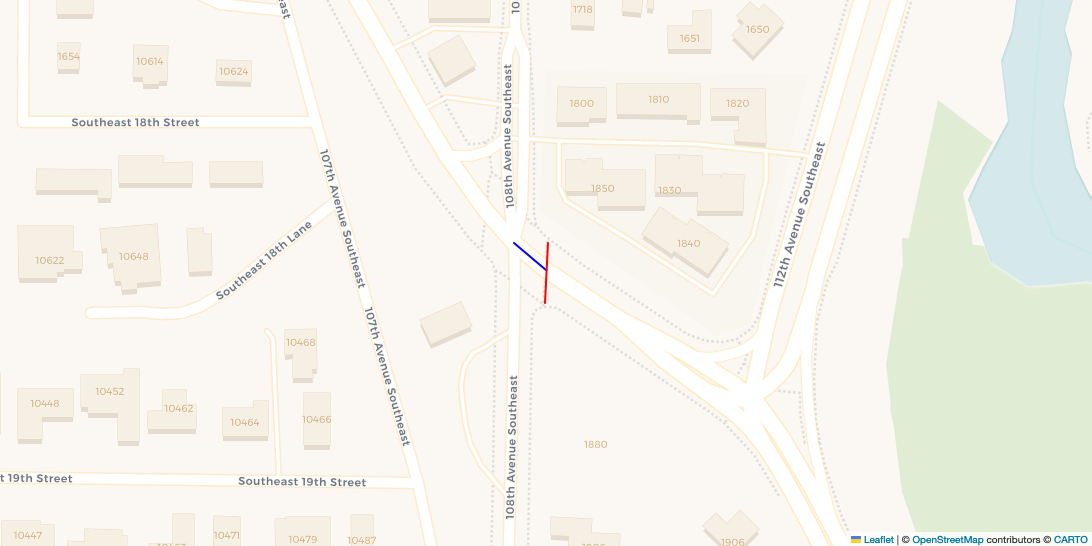

In [127]:
idx=14
if 'positive' in gpt4_wrong_predictions[idx]:
    img=Image.open(f'../../2024-spatial-join-exp/join_task_imgs/positive/{gpt4_wrong_predictions[idx]}.png')
else:
    img=Image.open(f'../../2024-spatial-join-exp/join_task_imgs/negative/{gpt4_wrong_predictions[idx]}.png')
img    